<p style="font-size:25px; text-align:center;">
Computational Physics / Numerische Verfahren in der Physik
<br>
<br>
SoSe 2023
</p>
<br>
<p style="font-size:15px; text-align:center">
Lorenz von Smekal, Ralf-Arno Tripolt, Robin Kehr, Johannes Roth, Leon Sieke
<br>Justus-Liebig-Universität Gießen
</p>
<br>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 2: Epidemieausbreitung
</b></p>
<p style="font-size:25px; color: #3776ab; text-align:center">
Populationsdynamik & Netzwerke
</p>
<div>
<p style="text-align:center">
<img src="figures/netzwerk.png" width="1000"/>
</p>
</div>


# Einführung


Infektionskrankheiten stellen eine ständige Bedrohung für die menschliche Zivilisation dar. Durch die moderne Medizin konnte ihre Verbreitung stark eingeschränkt werden. Schwere Pandemien, die ganze Landstriche entvölkern ("Schwarzer Tod" 1347-1353), kommen nicht mehr vor. Es konnten jedoch nur sehr wenige Krankheiten ausgerottet werden, und es kommen immer neue Erreger hinzu. In den letzten Jahren hat die Gefährlichkeit der neuen Erreger stark zugenommen und viele der dadurch verursachten Krankheiten können nur unzureichend behandelt werden (z.B. SARS, HUS oder aktuell SARS-CoV-2). Deshalb ist es sehr wichtig, die Dynamik von Infektionskrankheiten in der Bevölkerung gut zu verstehen, um so aus der Kombination aller zur Verfügung stehenden Maßnahmen sinnvolle Strategien zur Eindämmung von Infektionskrankheiten zu erarbeiten. Die aktuelle COVID-19-Pandemie mit SARS-CoV-2 macht dies besonders deutlich.

In diesem Projekt soll die Dynamik von Epidemien auf einem Netzwerk simuliert werden. Die Knoten des Netzwerks werden durch Städte mit Flughäfen gebildet. Diese sind durch Kanten verbunden, auf denen Reiseverkehr stattfindet. Durch den Reiseverkehr durchmischen sich die Populationen.  Die Infektionskrankheit innerhalb der Städte wird mit dem SIR-Modell (Susceptible-Infected-Recovered) beschrieben. Die räumliche Ausbreitung der Krankheit ergibt sich aus der Kombination des SIR Modells, das jeweils auf eine Stadt beschränkt ist, und dem Reiseverkehr auf dem Netzwerk. Infizierte Personen reisen in eine Stadt, die bisher frei von Infektionen war, und stecken die dortige Bevölkerung mit der Krankheit an.

Ziel ist es die Dynamik von Infektionskrankheiten auf globaler Ebene zu simulieren, um ihr epidemiologisches Verhalten zu untersuchen und beispielsweise Kalkulationen über die Effektivität von Impfprogrammen anzufertigen.

### Benötigte Pakete

In [1]:
import pandas as pd # Datenverarbeitung
import numpy as np  # Numerische Berechnungen
import matplotlib.pyplot as plt # Visualisierung
import cartopy.crs as ccrs # Kartenprojektionen
from scipy.integrate import solve_ivp # Numerische Lösung von Differentialgleichungen


### SIR-Modell

Das SIR-Modell beschreibt die Ausbreitung einer Infektionskrankheit in einer Bevölkerung. Das Modell funktioniert analog zum bereits in den Übungen behandelten Lotka-Voltera Modell zur Beschreibung von Jäger-Beute-Populationen. Beim SIR-Modell werden drei Gruppen von Individuen unterschieden: Zum Zeitpunkt $t$ bezeichnet $S(t)$ die Anzahl der gegen die Krankheit nicht immunen Gesunden (susceptible individuals), $I(t)$ die Zahl der ansteckenden Infizierten (infectious individuals) sowie $R(t)$ die Anzahl der aus dem Krankheitsgeschehen „entfernten“ Personen (removed individuals). Letzteres erfolgt entweder durch Genesen mit erworbener Immunität gegen die Krankheit oder durch Versterben. Weiterhin sei $N$ die Gesamtzahl der Individuen, das heißt: $ N = I + S + R $.

Der einfacheren Schreibweise wegen wird die Zeitabhängigkeit bei $N = N(t)$ , $R = R(t)$ , $S = S(t)$ , $I = I(t)$ im Folgenden weggelassen.

Das SIR-Modell berücksichtigt dabei die folgende Dynamik:

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S I}{N},\tag{1}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \beta \frac{S I}{N} -\gamma I,\tag{2}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I\tag{3}
\end{align}

- Die S-Population wird von der I-Population mit der Krankheit infiziert. Die Infektionsrate ergibt sich aus dem Produkt der Anzahl der infizierbaren Personen, einem Ansteckungsparameter $\beta$ und dem Anteil der Infizierten an der Gesamtbevölkerung. Der Parameter $\beta$ ist charakteristisch für die Krankheit und ergibt sich aus der Wahrscheinlichkeit, sich bei Kontakt mit einer infizierten Person anzustecken, und der Anzahl entsprechender Kontakte.

- Individuen der I-Population genesen (oder sterben) nach einer gewissen Zeit und sind danach gegen die Krankheit immun, gehen also in die R-Population über. Die entsprechende Übergangsrate  $\gamma$ entspricht der inversen Dauer der Krankheit.

Sie können das Modell im Rahmen der weiterführenden Aufgaben beliebig erweitern. Für die Basisaufgaben soll jedoch nur diese einfache Version verwendet werden. Mehr Informationen zum SIR-Modell und möglichen Erweiterungen finden Sie in den folgenden Wikipedia-Artikeln (und den darin enthaltenen Referenzen):
- [https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)
- [https://de.wikipedia.org/wiki/SIR-Modell](https://de.wikipedia.org/wiki/SIR-Modell)

### Netzwerk

Das Netzwerk, das wir betrachten, besteht aus 508 Knoten und 9294 Kanten.
Die Knoten des Netzwerks werden durch alle weltweiten Flughäfen gebildet, die durch einen IATA-Flughafencode gekennzeichnet sind (z.B. steht 'FRA' für den Flughafen Frankfurt).
Die Kanten werden durch alle Flugrouten gebildet, die weltweit betrieben werden.

Sowohl die Flughäfen- als auch die Routen-Datensätze stammen von [OpenFlights.org](https://openflights.org/) und sind öffentlich zugänglich.
Der Programmcode zur Erzeugung des Netzwerkes wird am Ende des Notebooks zur Verfügung gestellt und darf zur Bearbeitung des Projekts übernommen und ggf. abgeändert werden.


<img src="./figures/netzwerk_europa.png" width="600"/>

Die Daten können wie folgt eingelesen werden:

In [2]:
airports = pd.read_csv('./datasets/cleaned_data/airports_cleaned.csv')
routes = pd.read_csv('./datasets/cleaned_data/routes_cleaned.csv')
routes_matrix = pd.read_csv('./datasets/cleaned_data/routes_matrix_cleaned.csv', index_col=0)


### Reisemodell


Die Reisen in unserem Netzwerk beschreiben wir durch ein [Diffusionsmodell](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#SIR_model_with_diffusion). Dabei werden die Ratengleichungen des SIR-Modells um einen zusätzlichen Diffusionsterm ergänzt, der die räumliche Ausbreitung der jeweiligen Gruppen beschreibt:
\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = D_S \nabla^2 S -\beta \frac{S I}{N},\tag{4}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = D_I \nabla^2 I + \beta \frac{S I}{N} -\gamma I,\tag{5}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = D_R \nabla^2 R + \gamma I,\tag{6}
\end{align}

wobei $D_S$, $D_I$ und $D_R$ Diffusionskonstanten sind, die die Reiseraten der einzelnen Gruppen beschreiben. Diese sollen für die Basisaufgaben als identisch angenommen werden.

Auf dem diskreten Netzwerk, das wir betrachten, ist der Laplace-Operator $\nabla^2$ definiert als

\begin{equation}
    \nabla^2 C_i(t) = \sum_{j\sim\, i}^{\mathrm{deg}(i)}\frac{\bigl[C_j(t) - C_i(t)\bigr]}{{\mathrm{deg}(i)}},\quad \text{mit } C \in \{S, I, R\}.\tag{7}
\end{equation}

Hierbei steht der Index $i$ für eine bestimmte Stadt des Netzwerkes, (z.B. Frankfurt / FRA). Die Summe läuft dabei über alle Städte $j$ die mit der Stadt $i$ eine Flugverbindung teilen. $\mathrm{deg}(i)$ ist die Anzahl der Flugverbindungen der Stadt $i$.

Dieses Reismodell hat jedoch noch ein Problem. Da die Einwohnerzahlen der Städte unterschiedlich sind, würden durch die Diffusion die Einwohnerzahlen der Städte nicht konstant bleiben. Sondern es würden so lange Reisen stattfinden, bis diese in allen Städten gleich wäre. Um dies zu verhindern betrachten wir stattdessen die Diffusion der *relativen* SIR-Populationen $c_i(t) = \frac{C_i(t)}{N_i}$, wobei $N_i$ die Einwohnerzahl der Stadt $i$ ist. Die Diffusionsgleichung $(7)$ lautet in abgeänderter Form dann:

\begin{equation}
    \nabla^2 \frac{C_i(t)}{N_i} = \sum_{j\sim\, i}^{\mathrm{deg}(i)}\frac{\bigl[\frac{C_j(t)}{N_j} - \frac{C_i(t)}{N_i}\bigr]}{{\mathrm{deg}(i)}},\quad \text{mit } C \in \{S, I, R\}.\tag{8}
\end{equation}

Den Faktor $N_i$ können wir noch auf die rechte Seite der Gleichung multiplizieren, und erhalten damit unsere Reisedynamik für die *absoluten* SIR-Populationen:

\begin{equation}
    \frac{\mathrm{d} C}{\mathrm{d} t} = D\, \nabla^2 C_i(t) = D \sum_{j\sim\, i}^{\mathrm{deg}(i)}\frac{\bigl[\frac{N_i}{N_j}C_j(t) - C_i(t)\bigr]}{{\mathrm{deg}(i)}},\quad \text{mit } C \in \{S, I, R\}.\tag{9}
\end{equation}



Da die zur Verfügung stehende Rechenleistung begrenzt ist, werden wir die Dynamik vereinfachen, indem wir zusätzlich annehmen, dass alle Reisen quasi instantan ablaufen, d.h. in jedem Zeitschritt erfolgt eine sofortige Durchmischung. Ansteckungen in Verkehrsmitteln werden nicht extra berücksichtigt. Das führt dazu, dass wir die lokale SIR-Dynamik von der Reisedynamik trennen können und die Differenzielgleichungen nacheinander lösen können.

### Zeitentwicklung


In jedem Zeitschritt berechnen wir zuerst für jede Stadt $i$ die lokalen Änderungen der SIR-Populationen aufgrund des Infektionsgeschehens nach den Differenzialgleichungen $(1) - (3)$. Anschließend berechnen wir für jede Stadt $i$ die Änderungen der SIR-Populationen aufgrund der Reisedynamik nach der Differenzialgleichung $(9)$.

Das Modell soll so ausgelegt werden, dass ein Zeitschritt genau einem Tag entspricht. Die Parameter des SIR-Modells müssen entsprechend gewählt werden.

# Aufgaben

### Basisaufgaben

- Machen Sie sich mit dem Modell vertraut und überlegen Sie sich, wie realistisch es ist. Was wird korrekt abgebildet und was nicht?
- Das Netzwerk wird Ihnen zur Verfügung gestellt. Lesen Sie die Daten ein und machen Sie sich damit vertraut.
- Implementieren Sie Funktionen, um die Änderung der Populationen in einer Stadt aufgrund der Reisebewegungen zu berechnen.
- Implementieren Sie drei Funktionen, um die Änderung der Populationen in einer Stadt aufgrund der lokalen SIR-Dynamik zu berechnen, jede mit einer anderen Strategie zur Lösung der Differenzialgleichungen. Verwenden Sie die folgenden Verfahren:
  - ein Schritt des in der Vorlesung erwähnten Runge-Kutta-Verfahrens 4. Ordnung  
  - ein Schritt des in der Vorlesung erwähnten Euler-Verfahrens  
  - die scipy-Funktion `solve_ivp` mit der Standardmethode `method='RK45'`

- Fassen Sie diese Funktionen zusammen, um sie auf das gesamte Netzwerk anzuwenden. Halten Sie sich beim ausführen eines Zeitschrittes an die folgende Reihenfolge:
  1. Änderungen der Populationen in jeder Stadt aufgrund der lokalen SIR-Dynamik.
  2. Änderungen der Populationen in jeder Stadt aufgrund der Reisebewegungen.

#### Testen der Implementation


Anhand einiger einfacher Tests sollen Sie überprüfen, ob Ihre Implementation grobe Fehler enthält.

- Wie verhält sich das Modell, wenn es keine infizierten Personen gibt?
- Können Sie anhand der Differenzialgleichungen Grenzfälle für bestimmte Parameter erkennen? Überprüfen Sie diese Grenzfälle mit Ihrem Modell.
- Starten Sie eine Krankheit mit $\beta = 0.7$ und $\gamma = 0.07$ und einer Reiserate von $D = 0.01$ mit 1000 Infizierten in Frankfurt (FRA). Führen Sie 30 Zeitschritte aus. Untersuchen Sie das Verhahalten für alle drei Lösungsverfahren. Worin liegen die Stärken und Schwächen der einzelnen Verfahren? Welche der drei Implementationen halten Sie für die geeignetste?
- Betrachten Sie drei verschieden Krankheiten. Versuchen Sie aus zugänglichen Informationen sinnvolle Parameter abzuleiten.

#### Graphische Darstellung

- Erstellen Sie eine Animation einer Krankheit auf einer Europakarte, wählen Sie die Parameter so dass man die Ausbreitung der Krankheit gut erkennen kann.

### Weiterführende Aufgaben

Bearbeiten Sie Fragestellungen für insgesamt 4 Punkte aus der folgenden Liste, oder überlegen Sie sich gerne auch eigene Fragestellungen, diese müssen bzgl. der Punktvergabe jedoch vorher mit uns abgesprochen werden.

- Wie lassen sich Maßnahmen zur Eindämmung von Infektionen in dieses Modell einbauen? Solche Maßnahmen können zum Beispiel Informations- oder Impfkampagnen, Reisebeschränkungen, Social Distancing oder Flughafenschließungen sein. Wie stark müssen die Maßnahmen umgesetzt werden, um einen Effekt zu erzielen? Für welche Krankheiten eignen sich welche Maßnahmen besonders gut/schlecht und warum? (0,5 Punkte pro Maßnahme)

- Erweitern Sie das SIR-Modell durch eine vierte Gruppe X, welche Personen beinhaltet, die in Quarantäne sind oder durch Kontaktbeschränkungen oder Verhaltensveränderungen nicht mehr an der Ausbreitung teilnehmen (SIR-X-Modell, https://science.sciencemag.org/content/368/6492/742). Die Kontaktreduzierung von Infizierten wird durch einen Parameter $\kappa$ bestimmt ($\kappa$ = 0: keine Quarantäne). Kontaktreduzierungen für alle werden durch einen Parameter $\kappa_0$ bestimmt. Wie unterscheidet sich der Verlauf einer Epidemie im Vergleich zu einer ungestörten Ausbreitung, wie sie durch das SIR-Modell beschrieben wird? (1 Punkt)

- Erweitern Sie das SIR-X-Modell, so dass asymptomatisch Kranke, welche also nicht als krank erkannt werden aber dennoch infektiös sind, berücksichtigt werden können. (1 Punkt)

- Erweitern Sie das SIR-Modell, indem Sie weitere Gruppen einführen. Modellieren Sie dadurch zum Beispiel die Inkubationszeit oder eine zeitlich beschränkte Immunität. (je 1 Punkt)

- Inkludieren Sie die Möglichkeit, dass Menschen an der Krankheit sterben. (1 Punkt)

- Der Ansteckungsparameter $\beta$ hängt von der Kontaktrate und der Ansteckungsrate ab. Ersterer lässt sich zum Beispiel durch Maßnahmen wie Social Distancing, zweiterer zum Beispiel durch das Tragen von Masken verändern. Schätzen Sie für verschiedene Krankheiten ab, wie effektiv verschiedene Maßnahmen sind, indem Sie Änderungen von $\beta$ berücksichtigen. (1 Punkt)

- Erweitern Sie das SIR-Modell so, dass unterschiedliche Ansteckungsraten für Teile der Bevölkerung möglich sind. Dies kann aus biologischen Gründen relevant sein (manche Überträger haben z.B. eine besonders hohe Virenlast). Auch eine erhöhte Kontaktrate mancher Berufsgruppen kann dazu führen, dass eine Krankheit dadurch vermehrt übertragen wird. Wie unterscheidet sich die Ausbreitung einer Krankheit, wenn Superspreading eine besondere Rolle spielt? (2 Punkte)

- Variieren Sie die Krankheitsparameter $\beta$ und $\gamma$ mit der Zeit, um saisonal auftretende Infektionen (Grippe) oder Kontaktbeschränkungen zu beschreiben. (1 Punkt)

- Oft sind die genauen Parameter des Modells nicht exakt bekannt. Zum Teil unterscheiden sie sich auch in verschiedenen Regionen, da sie zum Beispiel von den Hygienebedingungen oder gesellschaftlichen Umständen abhängen. Letztendlich sind sie auch zeitlich nicht konstant, da das Wissen um eine Epidemie das menschliche Verhalten ändert. Untersuchen Sie die unterschiedlichen Auswirkungen, wenn die Parameter $\beta$ und $\gamma$ nicht exakt bekannt sind. Als Beispiel können Sie Schätzungen des Robert-Koch-Instituts für SARS-CoV-2 verwenden (1 Punkt): $1/10 < \gamma < 1/8$ und $0.28 < \beta < 0.48$.

- Erstellen Sie ein weiteres Netzwerk für z.B. Nordamerika (USA und Kanada) und verbinden Sie es über Flughäfen mit Europa. (1 Punkt)

- Werden Sie kreativ, und benutzen Sie Ihr Modell um Phänomene jenseits der Ausbreitung von Krankheiten zu untersuchen. Hier finden Sie Inspiration für mögliche Anwendungen in den Bereichen der Soziologie, Informatik, Ökonomie und Science Fiction: https://arxiv.org/pdf/1611.02565.pdf (je 1 Punkt)

# Anhang

### Beschriebung der Flughafen Daten

<table>
		<tr>
		  <td class="head">Airport ID</td>
		  <td class="data">Unique OpenFlights identifier for this airport.
		</td></tr>
		<tr>
		  <td class="head">Name</td>
		  <td class="data">Name of airport.  May or may not contain the <b>City</b> name.</td>
		</tr>
		<tr>
		  <td class="head">City</td>
		  <td class="data">Main city served by airport.  May be spelled differently from <b>Name</b>.</td>
		</tr>
		<tr>
		  <td class="head">Country</td>
		  <td class="data">Country or territory where airport is located.  See <a href="#country">Countries</a> to cross-reference to ISO 3166-1 codes.
		  </td>
		</tr>
		<tr>
		  <td class="head">IATA</td>
		  <td class="data">3-letter IATA code. (Of the airpot)  Null if not assigned/unknown.</td>
		</tr>
		<tr>
		  <td class="head">ICAO</td>
		  <td class="data">4-letter ICAO code. (Of the airpot)<br>
		    Null if not assigned.</td>
		</tr>
		<tr>
		  <td class="head">Latitude</td>
		  <td class="data">Decimal degrees, usually to six significant digits.  Negative is South, positive is North.</td>
		</tr>
		<tr>
		  <td class="head">Longitude</td>
		  <td class="data">Decimal degrees, usually to six significant digits.  Negative is West, positive is East.</td>
		</tr>
		<tr>
		  <td class="head">Altitude</td>
		  <td class="data">In feet.</td>
		</tr>
		<tr>
		  <td class="head">Timezone</td>
		  <td class="data">Hours offset from UTC.  Fractional hours are expressed as decimals, eg. India is 5.5.</td>
		</tr>
		<tr>
		  <td class="head">DST</td>
		  <td class="data">Daylight savings time.  One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). <i>See also: <a target="_blank" href="help/time.html">Help: Time</a></i><a target="_blank" href="help/time.html">
		</a></td></tr>
		<tr>
		  <td class="head">Tz database time zone</td>
		  <td class="data">Timezone in <a href="http://en.wikipedia.org/wiki/Tz_database">"tz" (Olson) format</a>, eg. "America/Los_Angeles".
		</td></tr>
		<tr>
		  <td class="head">Type</td>
		  <td class="data">Type of the airport.  Value "airport" for air terminals, "station" for train stations, "port" for
		  ferry terminals and "unknown" if not known.  <i>In airports.csv, only type=airport is included.</i>
		</td></tr>
		<tr>
		  <td class="head">Source</td>
		  <td class="data">Source of this data.  "OurAirports" for data sourced from <a href="http://ourairports.com/data/">OurAirports</a>, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions.  <i>In airports.csv, only source=OurAirports is included.</i>
		</td></tr>
	      
</table>

### Beschreibung der Flugrouten Daten

<table>
    <tr>
      <td class="head">Airline</td>
      <td class="data">2-letter (IATA) or 3-letter (ICAO) code of the airline.
    </td></tr>
    <tr>
      <td class="head">Airline ID</td>
      <td class="data">Unique OpenFlights identifier for airline (see <a href="#airline">Airline</a>).
    </td></tr>
    <tr>
      <td class="head">Source airport</td>
      <td class="data">3-letter (IATA) or 4-letter (ICAO) code of the source airport.<br>
    </td></tr>
    <tr>
      <td class="head">Source airport ID</td>
      <td class="data">Unique OpenFlights identifier for source airport (see <a href="#airport">Airport</a>)
    </td></tr>
    <tr>
      <td class="head">Destination airport</td>
      <td class="data">3-letter (IATA) or 4-letter (ICAO) code of the destination airport.<br>
    </td></tr>
    <tr>
      <td class="head">Destination airport ID</td>
      <td class="data">Unique OpenFlights identifier for destination airport (see <a href="#airport">Airport</a>)
    </td></tr>
    <tr>
      <td class="head">Codeshare</td>
      <td class="data">"Y" if this flight is a codeshare (that is, not operated by <i>Airline</i>, but another carrier), empty otherwise.</td>
    </tr>
    <tr>
      <td class="head">Stops</td>
      <td class="data">Number of stops on this flight ("0" for direct)</td>
    </tr>
    <tr>
      <td class="head">Equipment</td>
      <td class="data">3-letter codes for plane type(s) generally used on this flight, separated by spaces</td>
    </tr>
</table>

### Importieren und Bereinigen der Daten

In [3]:
def import_and_clean_data():
    """Returns cleaned airports and routes dataframes"""
    ###########################
    ### Import the raw data ###
    ###########################

    airports = pd.read_csv('./datasets/raw_data/airports.csv')
    airports.columns = ['airport_id', 'name', 'city', 'country', 'IATA', 'ICAO', 'latitude',
                        'longitude', 'altitude', 'timezone', 'DST', 'tz', 'type', 'source']

    airport_populations = pd.read_csv(
        './datasets/raw_data/airport_populations.csv')
    airport_populations.columns = ['IATA', 'population']

    routes = pd.read_csv('./datasets/raw_data/routes.csv')
    routes.columns = ['airline', 'airline_id', 'source_airport', 'source_airport_id',
                      'destination_airport', 'destination_airport_id', 'codeshare', 'stops',
                      'equipment']

    ##########################################
    ### Clean the airports and routes data ###
    ##########################################

    # Merge the airports and airport_populations dataframes
    airports = airports.merge(airport_populations, on='IATA')

    # Remove airports outside of Europe, we don't consider Russia as part of Europe
    airports = airports[airports['tz'].str.contains('Europe')]
    airports = airports[~airports['country'].str.contains('Russia')]

    #Only keep interesting columns
    airports = airports[['name', 'city', 'country',
                         'IATA', 'latitude', 'longitude', 'population']]
    routes = routes[['source_airport', 'destination_airport']]

    # Remove Null values
    airports.dropna(inplace=True)
    routes.dropna(inplace=True)

    # Only keep routes with source and destination inside of Europe
    routes = routes[(routes['source_airport'].isin(airports['IATA'].values))
                    & (routes['destination_airport'].isin(airports['IATA'].values))]

    # Only keep airports with incoming and outgoing routes inside of europe
    airports = airports[(airports['IATA'].isin(routes['source_airport'].values))
                        & (airports['IATA'].isin(routes['destination_airport'].values))]

    # Remove routes between airports, that we just threw out
    routes = routes[(routes['source_airport'].isin(airports['IATA'].values))
                    & (routes['destination_airport'].isin(airports['IATA'].values))]

    # Remove duplicate routes
    routes = routes.drop_duplicates()

    # Sort airports and routes alphabetically
    airports = airports.sort_values(by='IATA')
    routes = routes.sort_values(by='source_airport')

    # Reset indices
    airports = airports.reset_index().drop(columns='index')
    routes = routes.reset_index().drop(columns='index')

    return airports, routes

def create_route_matrix(routes):
    """Returns a matrix with ones where there is a route between airports and zeros otherwise"""
    # Create a sorted list of all airport IATA codes
    airport_IATAs = list(
        set(routes['source_airport'].unique()).union(
            set(routes['destination_airport'].unique()))
    )

    airport_IATAs.sort()

    # Create a mapping from airport IATA codes to indices
    idx_mapping = {node: idx for idx, node in enumerate(airport_IATAs)}

    # Create the routes matrix
    n_airports = len(airport_IATAs)
    Y = np.zeros((n_airports, n_airports))
    for source, destination in routes.values:
        Y[idx_mapping[source], idx_mapping[destination]] = 1
        # Symmetric because we assume that there are routes in both directions
        Y[idx_mapping[destination], idx_mapping[source]] = 1

    # Convert to pandas dataframe
    df = pd.DataFrame(Y)
    df.index = pd.Index(airport_IATAs)
    df.columns = airport_IATAs

    return df


airports, routes = import_and_clean_data()

routes_matrix = create_route_matrix(routes)

# Export cleaned data
airports.to_csv('./datasets/cleaned_data/airports_cleaned.csv', index=False)
routes.to_csv('./datasets/cleaned_data/routes_cleaned.csv', index=False)
routes_matrix.to_csv('./datasets/cleaned_data/routes_matrix_cleaned.csv', index=True)

### Graphische Darstellung des Netzwerkes

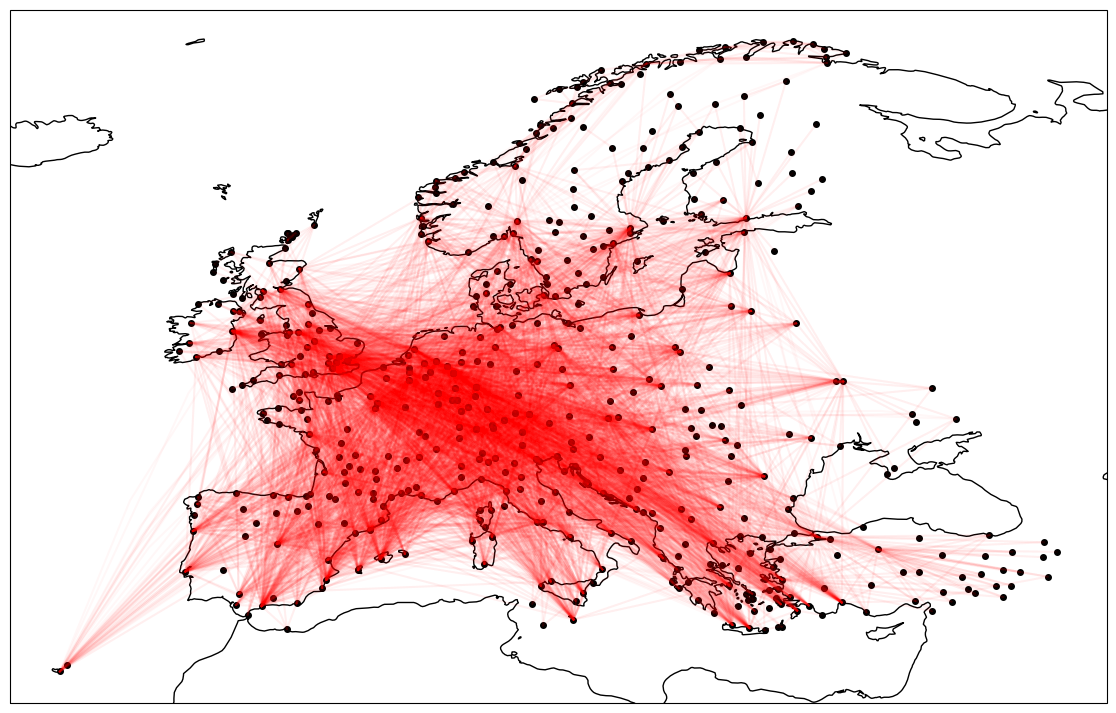

In [4]:
def plotNetworkOnMap(airports, routes_matrix, show_routes=False):
    """Stellt das Netzwerk auf einer Karte dar."""
    plt.figure(figsize=(16, 9))

    # Create a new map with the PlateCarree projection.
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines to the map
    ax.coastlines() # type: ignore

    #########################
    ### Plot all airports ###
    #########################

    # Create a mapping from airport IATA codes to latitudes and longitudes
    airport_IATA_to_lat_lon = {row[0]: {'lat': row[1], 'lon': row[2]}
                               for row in airports[['IATA', 'latitude', 'longitude']].values}

    # Plot airports
    for airport in routes_matrix.columns.values:
        pos = airport_IATA_to_lat_lon[airport]
        ax.plot(pos['lon'], pos['lat'], 'o',
                transform=ccrs.Geodetic(), c='k', markersize=4)

    ##########################################################
    ###                 Plot all routes                    ###
    ### Note: This can take a long time for large networks ###
    ##########################################################

    if (show_routes):
        n = routes_matrix.shape[0]
        for i in range(n):
            for j in range(n):
                source_pos = airport_IATA_to_lat_lon[routes_matrix.index[i]]

                if routes_matrix.iloc[i, j] != 0:
                    dest_pos = airport_IATA_to_lat_lon[routes_matrix.columns[j]]
                    ax.plot([source_pos['lon'], dest_pos['lon']],
                            [source_pos['lat'], dest_pos['lat']],
                            transform=ccrs.Geodetic(),
                            c='r', alpha=0.03, markersize=.1)

    plt.show()


plotNetworkOnMap(airports, routes_matrix, show_routes=True)
